In [1]:
from elasticsearch import Elasticsearch
from deepface import DeepFace
import matplotlib.pyplot as plt
from retinaface import RetinaFace
import os
import time
import glob

Matplotlib is building the font cache; this may take a moment.


In [2]:
es = Elasticsearch(hosts=['http://localhost:9200'], http_auth=('elastic', 'DkIed99SCb'))

In [3]:
model_name = 'ArcFace'
target_size = (160, 160)
embedding_size = 512

In [5]:
mapping = {
    "mappings": {
        "properties": {
            "title_vector":{
                "type": "dense_vector",
                "dims": embedding_size
            },
            "title_name": {"type": "keyword"}
        }
    }
}
   
es.indices.create(index="policedb", body=mapping)

RequestError: RequestError(400, 'resource_already_exists_exception', 'index [policedb/bpn17w8kTeuqumKMpbt-zA] already exists')

In [28]:
dir_path = "dataset/police/*.*"
res = glob.glob(dir_path, recursive=True)
files = []
for item in res:
    if item.endswith('.jpg'):
        files.append(item)
print('total files:', len(files))

total files: 5910


In [29]:
index = 0
tic = time.time()

for img_path in files:
    print('indexing', img_path)
    try:
        embedding_objs = DeepFace.represent(img_path=img_path, 
            model_name = model_name,
            detector_backend = 'retinaface'
        )
        embedding = embedding_objs[0]["embedding"]
        doc = {"title_vector": embedding, "title_name": img_path}
        es.create("policedb2", id=index, body=doc)
    except:
        pass

    index = index + 1
toc = time.time()
print("indexing completed in ",toc-tic," seconds")

indexing dataset/police/2008026.jpg
indexing dataset/police/2101016.jpg
indexing dataset/police/2108032.jpg
indexing dataset/police/2001002.jpg
indexing dataset/police/2001016.jpg
indexing dataset/police/2108026.jpg
indexing dataset/police/2101002.jpg
indexing dataset/police/2008032.jpg
indexing dataset/police/2110127.jpg
indexing dataset/police/2012042.jpg
indexing dataset/police/2006037.jpg
indexing dataset/police/2104152.jpg
indexing dataset/police/2010133.jpg
indexing dataset/police/2106023.jpg
indexing dataset/police/2004146.jpg
indexing dataset/police/2106037.jpg
indexing dataset/police/2004152.jpg


In [4]:
target_img_path = "dataset/targets/1.jpeg"
embedding_objs = DeepFace.represent(img_path = target_img_path, 
  model_name = model_name,
  detector_backend = 'retinaface'
)
target_embedding = embedding_objs[0]["embedding"]

In [5]:
query = {
    "size": 5,
    "query": {
    "script_score": {
        "query": {
            "match_all": {}
        },
        "script": {
            #"source": "cosineSimilarity(params.queryVector, 'title_vector') + 1.0",
            "source": "1 / (1 + l2norm(params.queryVector, 'title_vector'))", #euclidean distance
            "params": {
                "queryVector": list(target_embedding)
            }
        }
    }
}}

In [6]:
tic = time.time()
res = es.search(index="policedb", body=query)
toc = time.time()

print(toc-tic," seconds")

0.49890685081481934  seconds


dataset/police/1905005.jpg . Score:  0.23087208


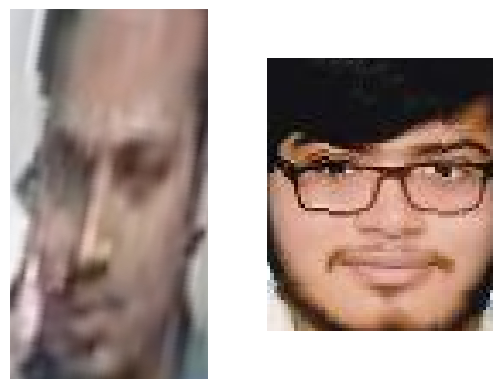

-------------------------
dataset/police/1806092.jpg . Score:  0.21876238


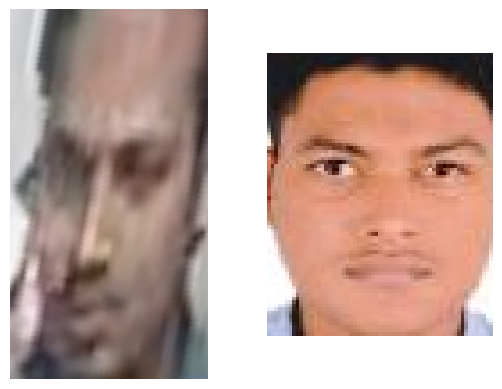

-------------------------
dataset/police/2002040.jpg . Score:  0.21539925


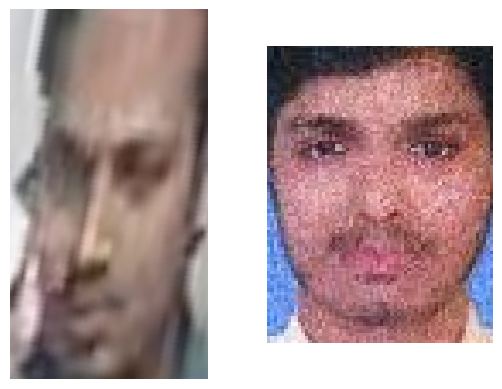

-------------------------
dataset/police/2006109.jpg . Score:  0.2148613


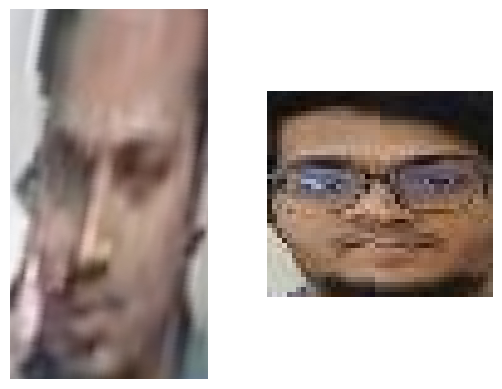

-------------------------
dataset/police/1804144.jpg . Score:  0.21264522


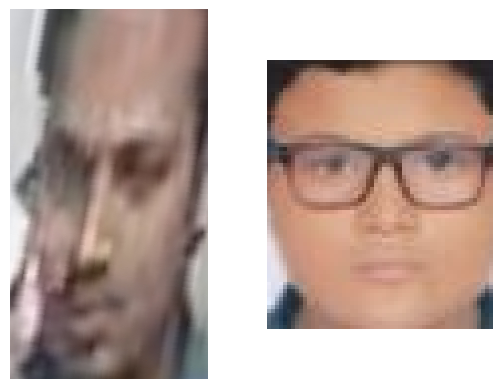

-------------------------


In [7]:
target_faces = RetinaFace.extract_faces(img_path = target_img_path, align = True)
target_img = target_faces[0]

for i in res["hits"]["hits"]:
    candidate_name = i["_source"]["title_name"]
    candidate_score = i["_score"]
    print(candidate_name, ". Score: ", candidate_score)
    candidate_faces = RetinaFace.extract_faces(img_path = candidate_name, align = True)
    candidate_img = candidate_faces[0]

    fig = plt.figure()

    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(target_img)
    plt.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(candidate_img)
    plt.axis('off')

    plt.show()

    print("-------------------------")